# Data pre-processing

In [31]:
import os
import struct
import numpy as np
import time
import random
import csv

In [68]:
def load_data(path):
    data = csv.reader(open(path,'r'))
    labels=[]
    images=[]
    for item in data:
        labels.append(item[1])
        images.append(item[2:])   
    # data[0] is the lable of each column
    # item[0] is the index of images
    # omit these 2 things 
    labels.pop(0)
    images.pop(0)
    return np.array(images,dtype=np.float64),np.array(labels,dtype=np.int32)

In [33]:
# data path
training_data = 'trainData.csv'
test_data = 'testData.csv'

In [34]:
# loading in data
X_train,y_train = load_data(training_data)
X_test,y_test = load_data(test_data)

In [35]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

tf.logging.set_verbosity(tf.logging.INFO)

# Create model

In [36]:
def cnn_clf(features, labels, mode):
  #Input layer
  input_layer = tf.reshape(features, [-1, 28, 28, 1])

  #Convolutional layer 1
  conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)

  #Pooling layer 1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  #Convolutional layer 2
  conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
  
  #Pooling layer 2
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  #Fully connected layer
  fc_input = tf.reshape(pool2, [-1, 7 * 7 * 64])
  fc = tf.layers.dense(inputs=fc_input, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(inputs=fc, rate=0.4, training= mode == learn.ModeKeys.TRAIN)

  #Softmax layer
  output = tf.layers.dense(inputs=dropout, units=10)

  loss = None
  train_op = None

  # Calculate Loss
  if mode != learn.ModeKeys.INFER:
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=output)

  # Configure the Training Op (for TRAIN mode)
  if mode == learn.ModeKeys.TRAIN:
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=0.001,
        optimizer="SGD")

  # Generate Predictions
  predictions = {
      "classes": tf.argmax(
          input=output, axis=1),
      "probabilities": tf.nn.softmax(
          output, name="softmax_tensor")
  }
  # Return a ModelFnOps object
  return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

# Create the Estimator
mnist_classifier = learn.Estimator(model_fn=cnn_clf, model_dir="/tmp/mnist_cnn_clf")

# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

# Train the model
mnist_classifier.fit(x=X_train,y=y_train,batch_size=100,steps=2000,monitors=[logging_hook])

# Configure the accuracy metric for evaluation
metrics = {"accuracy":learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes")}

# Evaluate the model and print results
eval_results = mnist_classifier.evaluate(x=X_test, y=y_test, metrics=metrics)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B7409CB668>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/mnist_cnn_clf'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_cnn_clf\model.ckpt-40
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 41 into /t

INFO:tensorflow:loss = 1.0255179405212402, step = 41
INFO:tensorflow:global_step/sec: 3.16501
INFO:tensorflow:probabilities = [[0.00041677 0.00023508 0.95243685 0.0003269  0.02247218 0.0021797
  0.00070808 0.00007627 0.0083748  0.01277336]
 [0.10298389 0.00580322 0.00002375 0.00001426 0.04238345 0.7356298
  0.05819647 0.00465416 0.03969666 0.01061433]
 [0.00080463 0.0000009  0.00000508 0.00004423 0.94634301 0.00006427
  0.00026892 0.04834425 0.00317039 0.00095431]
 [0.00029718 0.00013265 0.00011353 0.00083905 0.00003225 0.99648056
  0.00186903 0.00012486 0.00001904 0.00009184]
 [0.00000133 0.00000079 0.00000445 0.00000333 0.00000208 0.99996727
  0.00000029 0.00000581 0.00000664 0.000008  ]
 [0.00000701 0.00003533 0.00024677 0.00466174 0.00681632 0.00060465
  0.96971166 0.00108959 0.01494328 0.00188365]
 [0.00006323 0.94466735 0.01206453 0.0006993  0.00368443 0.00149089
  0.00500344 0.01493047 0.01700402 0.00039232]
 [0.00068561 0.00000562 0.97355411 0.00512178 0.00039137 0.00036579
  0

INFO:tensorflow:loss = 0.4140481650829315, step = 141 (31.593 sec)
INFO:tensorflow:global_step/sec: 3.24785
INFO:tensorflow:probabilities = [[0.14717218 0.00272431 0.09717699 0.00288419 0.1821808  0.44551697
  0.08260393 0.01622564 0.00000272 0.02351228]
 [0.99865417 0.00000044 0.00110618 0.00000328 0.0000194  0.00006438
  0.00000068 0.00000254 0.00013695 0.00001199]
 [0.99989983 0.00000009 0.00007043 0.00000009 0.00000639 0.00001732
  0.00000042 0.00000238 0.00000023 0.00000281]
 [0.00002637 0.0003335  0.00007697 0.00000702 0.00000748 0.00002216
  0.00000289 0.99933388 0.00000775 0.00018198]
 [0.0000003  0.00000336 0.00000988 0.71749123 0.00000019 0.28052259
  0.00060155 0.00004436 0.00002914 0.00129742]
 [0.00000329 0.00000029 0.00001681 0.00001899 0.01073102 0.00001106
  0.00000955 0.00107158 0.00000171 0.98813571]
 [0.84449561 0.00002722 0.0002346  0.13307357 0.00000179 0.00180003
  0.00000818 0.00000543 0.004885   0.01546856]
 [0.00801033 0.00009848 0.00008345 0.01177331 0.8185228

INFO:tensorflow:loss = 0.48586997389793396, step = 241 (30.790 sec)
INFO:tensorflow:global_step/sec: 3.16841
INFO:tensorflow:probabilities = [[0.09991767 0.00635677 0.89035422 0.00152588 0.00000743 0.00001905
  0.00073202 0.00000075 0.00022973 0.00085647]
 [0.00020163 0.00000164 0.97908491 0.01688277 0.00376446 0.00000728
  0.0000015  0.00000946 0.00000378 0.00004258]
 [0.00000152 0.00010201 0.00005365 0.00185897 0.0000394  0.99466822
  0.00269935 0.00000112 0.00051501 0.00006075]
 [0.00000019 0.00001089 0.00019828 0.98242223 0.00000008 0.01733446
  0.00000051 0.00000003 0.00002522 0.00000813]
 [0.00000002 0.00000028 0.00000095 0.00000002 0.00006683 0.00001038
  0.99991611 0.00000004 0.00000537 0.        ]
 [0.00011045 0.00000446 0.00001899 0.00000024 0.00000216 0.00002459
  0.00000001 0.99884398 0.00000899 0.00098613]
 [0.00001965 0.00000181 0.00000056 0.00213752 0.0000008  0.99708505
  0.00000217 0.00000037 0.000268   0.00048407]
 [0.00065587 0.00005084 0.00002095 0.99893581 0.000028

INFO:tensorflow:loss = 0.45517227053642273, step = 341 (31.563 sec)
INFO:tensorflow:global_step/sec: 3.13326
INFO:tensorflow:probabilities = [[0.00647934 0.00017551 0.00186508 0.86247817 0.001919   0.08417545
  0.02843542 0.00661884 0.00773626 0.00011695]
 [0.00027137 0.00005322 0.00711878 0.99078965 0.00022624 0.00017908
  0.00008253 0.00123254 0.00002145 0.00002515]
 [0.00000001 0.00000003 0.00000817 0.99985445 0.00000002 0.00012854
  0.         0.00000048 0.00000759 0.00000069]
 [0.00010258 0.00000234 0.00056062 0.00026149 0.00440189 0.01299599
  0.00079634 0.00124817 0.89327922 0.08635138]
 [0.00025657 0.00464819 0.00010416 0.00583021 0.11848907 0.71270541
  0.13762827 0.00006443 0.02017862 0.00009507]
 [0.97307133 0.00000017 0.0000196  0.00166636 0.00097201 0.0005246
  0.0006925  0.00109155 0.01335211 0.00860978]
 [0.00004054 0.00000002 0.00000011 0.0000005  0.99993041 0.00000002
  0.00000001 0.00000065 0.00000296 0.00002478]
 [0.00000013 0.00000013 0.00000007 0.00003965 0.0000018

INFO:tensorflow:loss = 0.11827347427606583, step = 441 (32.023 sec)
INFO:tensorflow:global_step/sec: 3.34236
INFO:tensorflow:probabilities = [[0.00053172 0.00000624 0.00022096 0.00002506 0.00000791 0.00019339
  0.00000101 0.99564238 0.00001913 0.0033522 ]
 [0.00000881 0.00000173 0.0001218  0.00000415 0.99950703 0.00000184
  0.00001882 0.00010591 0.00000212 0.00022777]
 [0.0000012  0.00002365 0.00000047 0.00000005 0.99989262 0.00007275
  0.0000048  0.00000251 0.00000127 0.00000068]
 [0.00007392 0.00246055 0.00001341 0.00001238 0.99741263 0.0000018
  0.00000328 0.00001866 0.0000022  0.00000116]
 [0.00001076 0.00025596 0.00000025 0.00002729 0.00069507 0.00000468
  0.99897567 0.00000461 0.00002403 0.00000169]
 [0.0000008  0.00000294 0.99999575 0.00000015 0.00000001 0.00000008
  0.00000004 0.         0.00000018 0.00000004]
 [0.99987073 0.0000001  0.00007025 0.00000688 0.00000042 0.00000397
  0.0000006  0.         0.00004522 0.00000182]
 [0.99974532 0.0000005  0.00000017 0.00022247 0.0000065

INFO:tensorflow:loss = 0.14902517199516296, step = 541 (29.809 sec)
INFO:tensorflow:global_step/sec: 3.32618
INFO:tensorflow:probabilities = [[0.         0.00000013 0.00000736 0.00000019 0.         0.00000004
  0.         0.99998984 0.00000135 0.00000109]
 [0.00000004 0.00000212 0.00011329 0.00030137 0.00129278 0.00101831
  0.00118831 0.03013414 0.00116779 0.96478186]
 [0.00000017 0.00009213 0.00000044 0.00000314 0.00071833 0.00000961
  0.99917545 0.00000006 0.00000061 0.00000005]
 [0.00007995 0.00000898 0.88928689 0.05301313 0.05698158 0.00022011
  0.00014638 0.0000325  0.00014152 0.00008896]
 [0.00000153 0.00003198 0.99981463 0.00000866 0.000033   0.00000025
  0.00005633 0.00000013 0.0000535  0.00000001]
 [0.00000008 0.00000238 0.000219   0.02101637 0.0000013  0.00002323
  0.00002802 0.00000054 0.97870908 0.00000001]
 [0.00124796 0.00000407 0.00258652 0.00000154 0.00003437 0.0000927
  0.99599403 0.00000714 0.00003163 0.00000003]
 [0.00000037 0.00000483 0.00021438 0.99905151 0.0000064

INFO:tensorflow:loss = 0.18286193907260895, step = 641 (30.073 sec)
INFO:tensorflow:global_step/sec: 3.33492
INFO:tensorflow:probabilities = [[0.99995725 0.00000001 0.00000001 0.00000003 0.00000001 0.00000949
  0.00000001 0.         0.00003156 0.00000164]
 [0.00000512 0.00000075 0.00000038 0.00000152 0.00011987 0.00001149
  0.9998569  0.00000004 0.0000039  0.00000002]
 [0.00004    0.00005784 0.00030588 0.00000906 0.9410693  0.00000558
  0.00000051 0.00127708 0.05668149 0.00055325]
 [0.00003025 0.00000464 0.00000015 0.00000069 0.00000016 0.00000074
  0.99996225 0.         0.00000103 0.0000001 ]
 [0.00241511 0.39958085 0.00788655 0.49138083 0.00013738 0.02288807
  0.06743292 0.00025112 0.0031017  0.00492547]
 [0.00000003 0.00000024 0.00000001 0.         0.99996697 0.
  0.0000005  0.00000155 0.0000238  0.0000069 ]
 [0.00000103 0.00000005 0.00000001 0.00004932 0.00000002 0.99985589
  0.00000032 0.00000095 0.00000184 0.00009057]
 [0.00000004 0.         0.00000001 0.         0.00001633 0.000

INFO:tensorflow:loss = 0.20391730964183807, step = 741 (29.977 sec)
INFO:tensorflow:global_step/sec: 3.34392
INFO:tensorflow:probabilities = [[0.00002243 0.00000061 0.99973938 0.00000513 0.00000003 0.00000011
  0.00020852 0.00002169 0.00000209 0.00000001]
 [0.00000355 0.00008766 0.00093383 0.99805548 0.00000034 0.00000265
  0.00005847 0.00030148 0.00055633 0.0000002 ]
 [0.00786976 0.00569719 0.01022847 0.00008602 0.00144325 0.00183463
  0.00002659 0.00497498 0.85191707 0.11592203]
 [0.00105675 0.98747128 0.00000812 0.0001365  0.00509537 0.00001369
  0.00031444 0.00580751 0.00006785 0.0000285 ]
 [0.00000147 0.00047001 0.99941727 0.00002483 0.0000009  0.00000095
  0.00000017 0.00006445 0.00001656 0.00000338]
 [0.00000001 0.00000003 0.00000031 0.00000008 0.99659948 0.00000065
  0.00002967 0.00024608 0.00038959 0.00273411]
 [0.94614432 0.0000272  0.0289325  0.0029662  0.00428203 0.00001329
  0.01740634 0.00014845 0.00000411 0.00007557]
 [0.00000087 0.99987288 0.00000138 0.00000168 0.000094

INFO:tensorflow:loss = 0.08501468598842621, step = 841 (29.906 sec)
INFO:tensorflow:global_step/sec: 3.33226
INFO:tensorflow:probabilities = [[0.00000275 0.9009751  0.00010084 0.00000056 0.09846218 0.00000171
  0.00000052 0.00040962 0.0000465  0.00000022]
 [0.75238006 0.00004664 0.00000917 0.00000501 0.00003429 0.00002195
  0.24743949 0.00000096 0.00002322 0.0000392 ]
 [0.00000337 0.00001933 0.94115346 0.00048972 0.00000094 0.00000174
  0.00988346 0.04844545 0.00000225 0.00000027]
 [0.99975997 0.00000003 0.         0.00000027 0.00000011 0.00022099
  0.00000017 0.         0.00001837 0.00000008]
 [0.00000512 0.0002017  0.00006188 0.98319494 0.000077   0.010823
  0.00044462 0.00004049 0.00515075 0.0000005 ]
 [0.00008073 0.00001604 0.0000024  0.86429893 0.00010325 0.13523965
  0.00018956 0.00000541 0.00006272 0.00000131]
 [0.0000002  0.         0.         0.00004013 0.00000002 0.99994841
  0.         0.00000002 0.00001094 0.00000028]
 [0.60779756 0.00001184 0.00353534 0.00002785 0.13800493

INFO:tensorflow:loss = 0.24987345933914185, step = 941 (30.395 sec)
INFO:tensorflow:global_step/sec: 3.30687
INFO:tensorflow:probabilities = [[0.00018709 0.00000004 0.0000004  0.00001873 0.00000572 0.00050922
  0.00001653 0.00390489 0.00000148 0.9953559 ]
 [0.         0.         0.00000001 0.99999997 0.         0.00000001
  0.         0.         0.         0.        ]
 [0.00000035 0.00000001 0.00002807 0.00018166 0.00000002 0.00000143
  0.00000128 0.00000013 0.99972745 0.00005959]
 [0.00002556 0.00000014 0.00001036 0.74271099 0.00013298 0.08173869
  0.00025409 0.00000061 0.17511753 0.00000907]
 [0.00000018 0.00000375 0.00000107 0.0001947  0.00000079 0.00013646
  0.00000392 0.00000001 0.99965821 0.00000092]
 [0.00000014 0.00000077 0.00000174 0.00000396 0.00000001 0.00000158
  0.00001225 0.00000007 0.99997923 0.00000025]
 [0.00000186 0.00000002 0.00000235 0.99982846 0.00000001 0.00005597
  0.00000036 0.00000022 0.00010491 0.00000584]
 [0.79781445 0.0000663  0.00099796 0.00000961 0.000736

INFO:tensorflow:loss = 0.12185085564851761, step = 1041 (29.857 sec)
INFO:tensorflow:global_step/sec: 3.34415
INFO:tensorflow:probabilities = [[0.99999623 0.00000002 0.00000023 0.00000003 0.         0.00000009
  0.         0.00000003 0.00000016 0.0000032 ]
 [0.00000048 0.00000005 0.00001328 0.00015628 0.00241177 0.00000714
  0.00000014 0.00001804 0.00053979 0.99685303]
 [0.00000036 0.00000004 0.         0.99994336 0.00000014 0.00000087
  0.00000001 0.00000014 0.00000006 0.00005502]
 [0.00201994 0.88421311 0.0108954  0.00048853 0.00052536 0.06561874
  0.00189196 0.00031751 0.0332675  0.00076194]
 [0.99999335 0.00000016 0.00000007 0.00000002 0.         0.00000611
  0.00000001 0.         0.0000001  0.00000018]
 [0.00029395 0.9959007  0.00061384 0.00118596 0.00088883 0.00059219
  0.00002613 0.00005865 0.00002929 0.00041046]
 [0.00380987 0.00250053 0.00118841 0.00023577 0.00013714 0.00019276
  0.00000333 0.00094679 0.003766   0.98721941]
 [0.00000053 0.99875241 0.00001569 0.0000325  0.00000

INFO:tensorflow:loss = 0.06904952228069305, step = 1141 (29.902 sec)
INFO:tensorflow:global_step/sec: 3.35702
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000001 0.00000008 0.
  0.         0.00028632 0.0000005  0.99971308]
 [0.00166437 0.00000019 0.00000008 0.00000298 0.02712297 0.00010687
  0.00000025 0.00024637 0.00054674 0.97030918]
 [0.00000436 0.00001246 0.00003779 0.00001392 0.99739703 0.00001076
  0.0001556  0.00157993 0.0001864  0.00060175]
 [0.         0.         0.99999996 0.00000004 0.         0.
  0.         0.         0.         0.        ]
 [0.00000014 0.00000028 0.00000001 0.00000052 0.96571901 0.00000138
  0.00000245 0.00001707 0.00001581 0.03424333]
 [0.00000022 0.00000029 0.00000653 0.99997813 0.         0.00001301
  0.         0.00000002 0.0000016  0.00000021]
 [0.00009579 0.00000212 0.00000098 0.00000136 0.00002388 0.02158631
  0.28537768 0.00000008 0.6929115  0.00000029]
 [0.00030977 0.00687409 0.0000933  0.03095488 0.00009767 0.00470697
 

INFO:tensorflow:loss = 0.093069888651371, step = 1241 (29.787 sec)
INFO:tensorflow:global_step/sec: 3.35399
INFO:tensorflow:probabilities = [[0.00106862 0.00000087 0.00007763 0.40531776 0.00009354 0.59327277
  0.00000399 0.00004445 0.00006517 0.00005519]
 [0.00000004 0.00000002 0.00000455 0.00000237 0.0001011  0.00000189
  0.         0.99986607 0.0000083  0.00001565]
 [0.00007176 0.99908966 0.00002645 0.00029769 0.0002236  0.00007755
  0.00016551 0.0000212  0.00001012 0.00001645]
 [0.00000158 0.         0.00000002 0.00000032 0.         0.00000001
  0.         0.99991281 0.         0.00008526]
 [0.00001836 0.00017245 0.00000246 0.00048257 0.99896262 0.00001023
  0.00000618 0.00017049 0.00003514 0.0001395 ]
 [0.00000021 0.00000049 0.00000841 0.00000034 0.99995707 0.00000003
  0.00000002 0.00000356 0.00002956 0.00000031]
 [0.00000003 0.00000001 0.00000004 0.00000648 0.         0.
  0.         0.99997867 0.00000001 0.00001476]
 [0.00000115 0.99972067 0.00025169 0.0000001  0.00000195 0.0000

INFO:tensorflow:loss = 0.03769417852163315, step = 1341 (29.814 sec)
INFO:tensorflow:global_step/sec: 3.35231
INFO:tensorflow:probabilities = [[0.         0.         0.00000136 0.00000003 0.         0.
  0.         0.9999986  0.         0.00000001]
 [0.00003051 0.99794311 0.00013033 0.00001316 0.00091143 0.00000009
  0.00068292 0.00012456 0.00016293 0.00000097]
 [0.00000007 0.         0.00000069 0.99999847 0.         0.00000002
  0.         0.0000003  0.         0.00000045]
 [0.00001456 0.00069472 0.00345528 0.03058897 0.00001074 0.00000029
  0.         0.96438479 0.0000098  0.00084085]
 [0.92697611 0.05022716 0.00204315 0.01022972 0.00555754 0.00004331
  0.00294358 0.00078178 0.00117961 0.00001804]
 [0.00001272 0.00000465 0.00000013 0.00011092 0.00004709 0.99959254
  0.00001085 0.00021377 0.00000563 0.0000017 ]
 [0.00000079 0.         0.00000009 0.00000004 0.         0.00011657
  0.         0.99988184 0.         0.00000068]
 [0.00000255 0.00000062 0.10717985 0.75418403 0.00000056 0.00

INFO:tensorflow:loss = 0.08445142954587936, step = 1441 (29.936 sec)
INFO:tensorflow:global_step/sec: 3.32067
INFO:tensorflow:probabilities = [[0.00007974 0.00085408 0.02323581 0.00537828 0.00008136 0.00000502
  0.00000013 0.97027921 0.00001165 0.00007471]
 [0.00000111 0.00000031 0.00003254 0.00009837 0.00000019 0.00542677
  0.00005645 0.0248839  0.00002246 0.96947791]
 [0.00016434 0.0001737  0.00000211 0.000902   0.0000034  0.99752266
  0.00037226 0.         0.00077366 0.00008587]
 [0.99983316 0.00000011 0.00005567 0.00000006 0.00000021 0.00000018
  0.00009748 0.         0.00001313 0.        ]
 [0.00000001 0.         0.00000003 0.00001733 0.         0.00000147
  0.00000039 0.         0.99998071 0.00000006]
 [0.00000608 0.00011748 0.00000126 0.00026663 0.00059833 0.99870151
  0.00010354 0.00000368 0.00019903 0.00000245]
 [0.96156556 0.00016298 0.00001395 0.00002227 0.0007205  0.00002312
  0.03728825 0.00000204 0.00004604 0.00015529]
 [0.00000008 0.99999098 0.         0.00000002 0.00000

INFO:tensorflow:loss = 0.051264915615320206, step = 1541 (30.012 sec)
INFO:tensorflow:global_step/sec: 3.34917
INFO:tensorflow:probabilities = [[0.00004947 0.00000295 0.00036577 0.00008964 0.00010105 0.00011375
  0.00000859 0.00002602 0.99914237 0.00010038]
 [0.00000002 0.         0.00001579 0.00000002 0.00000017 0.00000002
  0.         0.0000003  0.99998312 0.00000054]
 [0.00000001 0.99994676 0.00000044 0.00000001 0.00005118 0.00000006
  0.00000012 0.00000114 0.00000015 0.00000013]
 [0.00000036 0.00000001 0.00000003 0.00011681 0.00000002 0.00000005
  0.         0.99884304 0.00000028 0.0010394 ]
 [0.00088827 0.00000173 0.00075595 0.02451414 0.00004699 0.00005039
  0.0020029  0.00000001 0.97107194 0.00066768]
 [0.02630748 0.00122764 0.00005183 0.82590163 0.0002411  0.11718944
  0.00001254 0.00477977 0.00004046 0.0242481 ]
 [0.26871016 0.00031386 0.0028039  0.00035455 0.00278891 0.00000152
  0.00002764 0.00000257 0.72487697 0.00011992]
 [0.00000983 0.0000017  0.00063131 0.00006711 0.0161

INFO:tensorflow:loss = 0.08197779953479767, step = 1641 (29.857 sec)
INFO:tensorflow:global_step/sec: 3.32001
INFO:tensorflow:probabilities = [[0.         0.         0.         0.         0.00000001 0.
  0.99999998 0.         0.         0.        ]
 [0.00000008 0.99999432 0.00000398 0.00000058 0.00000017 0.00000007
  0.00000007 0.00000024 0.00000047 0.00000001]
 [0.00000019 0.00000002 0.00000011 0.0000004  0.         0.
  0.         0.99999805 0.         0.00000123]
 [0.00063142 0.00049557 0.00000394 0.00000405 0.0001603  0.00000005
  0.99870421 0.00000032 0.00000012 0.        ]
 [0.00000899 0.00000797 0.00000042 0.02451033 0.00001706 0.97338721
  0.00014351 0.0000034  0.00187641 0.00004471]
 [0.00000001 0.         0.00000025 0.00000713 0.99757215 0.00000006
  0.0000075  0.0001052  0.00000213 0.00230557]
 [0.99999632 0.00000213 0.00000002 0.00000001 0.00000024 0.
  0.00000035 0.         0.00000021 0.00000071]
 [0.00000157 0.         0.00000001 0.00000152 0.99999414 0.00000001
  0.00000

INFO:tensorflow:loss = 0.03154265508055687, step = 1741 (30.119 sec)
INFO:tensorflow:global_step/sec: 3.34069
INFO:tensorflow:probabilities = [[0.00000155 0.00029743 0.00000688 0.00000412 0.00011939 0.0000015
  0.         0.99590629 0.00000082 0.00366202]
 [0.99996527 0.00000008 0.00000299 0.00000021 0.00000001 0.00000205
  0.00000581 0.00000001 0.00002256 0.00000101]
 [0.00000024 0.         0.00000002 0.         0.00000479 0.00000023
  0.00000003 0.0004934  0.00000088 0.9995004 ]
 [0.00000035 0.         0.00000015 0.00000012 0.00000006 0.
  0.         0.00001704 0.00000613 0.99997615]
 [0.00000006 0.00000345 0.9999499  0.00002396 0.00000199 0.
  0.00000001 0.00000001 0.0000206  0.        ]
 [0.99982829 0.00000003 0.00000032 0.00000021 0.00000276 0.00000416
  0.00015157 0.00000042 0.00001196 0.00000028]
 [0.0000238  0.0000037  0.96704503 0.00084453 0.0000012  0.00000035
  0.03178836 0.00000522 0.00028781 0.        ]
 [0.00001033 0.         0.00000002 0.00000049 0.00000012 0.00214278
  

INFO:tensorflow:loss = 0.10134786367416382, step = 1841 (30.054 sec)
INFO:tensorflow:global_step/sec: 3.33037
INFO:tensorflow:probabilities = [[0.00000206 0.         0.99999331 0.00000004 0.         0.
  0.         0.00000418 0.00000041 0.00000001]
 [0.00000001 0.00000019 0.99703129 0.00000009 0.00011881 0.00000001
  0.00000005 0.00000101 0.0028439  0.00000464]
 [0.00000008 0.00000043 0.00003749 0.00002138 0.00000187 0.00000542
  0.00000129 0.         0.99993201 0.00000004]
 [0.00000012 0.000046   0.         0.00000006 0.00000074 0.00000269
  0.99995015 0.         0.00000024 0.        ]
 [0.00000284 0.00000431 0.00000031 0.00000195 0.00447385 0.00000003
  0.         0.99537007 0.00000394 0.00014268]
 [0.00000329 0.00000043 0.00000045 0.00000056 0.31566378 0.00000913
  0.00000001 0.00016795 0.00038139 0.683773  ]
 [0.00056608 0.14188824 0.00409932 0.00000006 0.83695196 0.00003375
  0.00021167 0.00364481 0.01244642 0.0001577 ]
 [0.99997523 0.00000037 0.00000097 0.00000102 0.00000007 0.00

INFO:tensorflow:loss = 0.10529466718435287, step = 1941 (29.907 sec)
INFO:tensorflow:Saving checkpoints for 2022 into /tmp/mnist_cnn_clf\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2040 into /tmp/mnist_cnn_clf\model.ckpt.
INFO:tensorflow:Loss for final step: 0.04248207062482834.
INFO:tensorflow:Starting evaluation at 2018-12-05-05:49:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_cnn_clf\model.ckpt-2040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-05:49:10
INFO:tensorflow:Saving dict for global step 2040: accuracy = 0.9795, global_step = 2040, loss = 0.07716114
{'accuracy': 0.9795, 'loss': 0.07716114, 'global_step': 2040}


# Different activation

# Relu

In [41]:
def cnn_relu(features, labels, mode):
  #Input layer
  input_layer = tf.reshape(features, [-1, 28, 28, 1])

  #Convolutional layer 1
  conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)

  #Pooling layer 1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  #Convolutional layer 2
  conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
  
  #Pooling layer 2
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  #Fully connected layer
  fc_input = tf.reshape(pool2, [-1, 7 * 7 * 64])
  fc = tf.layers.dense(inputs=fc_input, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(inputs=fc, rate=0.4, training= mode == learn.ModeKeys.TRAIN)

  #Softmax layer
  output = tf.layers.dense(inputs=dropout, units=10)

  loss = None
  train_op = None

  # Calculate Loss
  if mode != learn.ModeKeys.INFER:
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=output)

  # Configure the Training Op (for TRAIN mode)
  if mode == learn.ModeKeys.TRAIN:
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=0.001,
        optimizer="SGD")

  # Generate Predictions
  predictions = {
      "classes": tf.argmax(
          input=output, axis=1),
      "probabilities": tf.nn.softmax(
          output, name="softmax_tensor")
  }
  # Return a ModelFnOps object
  return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

# Create the Estimator
mnist_classifier1 = learn.Estimator(model_fn=cnn_relu, model_dir="/tmp/mnist_cnn_relu")

# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

# Train the model
mnist_classifier1.fit(x=X_train,y=y_train,batch_size=100,steps=500,monitors=[logging_hook])

# Configure the accuracy metric for evaluation
metrics = {"accuracy":learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes")}

# Evaluate the model and print results
eval_results1 = mnist_classifier1.evaluate(x=X_test, y=y_test, metrics=metrics)
print(eval_results1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B7001BED68>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/mnist_cnn_relu'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_cnn_relu\model.ckpt.
INFO:tensorflow:probabilities = [[1.         

INFO:tensorflow:loss = 42.86076354980469, step = 1
INFO:tensorflow:global_step/sec: 3.21267
INFO:tensorflow:probabilities = [[0.0000672  0.00000427 0.99941665 0.00004257 0.00003016 0.00000884
  0.00002842 0.00001188 0.0003852  0.00000481]
 [0.00039979 0.00020665 0.00060989 0.00024433 0.89383564 0.00134231
  0.05158115 0.00672769 0.04086387 0.00418868]
 [0.0000196  0.00026416 0.00099092 0.00005768 0.33326564 0.00008364
  0.01209441 0.000269   0.00010801 0.65284693]
 [0.00725035 0.00008755 0.00616212 0.00189882 0.00085581 0.97309453
  0.00040405 0.00113343 0.00283786 0.00627548]
 [0.00302682 0.00016925 0.00022365 0.0151754  0.00011281 0.9780223
  0.00157103 0.00008378 0.00106391 0.00055107]
 [0.00328496 0.00176897 0.32198117 0.00075996 0.05812567 0.00116671
  0.60856315 0.0001924  0.0029336  0.00122342]
 [0.00072464 0.44718401 0.13000851 0.00398743 0.00067648 0.00353905
  0.02430379 0.0012725  0.38812067 0.00018292]
 [0.00115626 0.00005084 0.65617178 0.2579839  0.00002573 0.00032643
  0.

INFO:tensorflow:loss = 0.5068286657333374, step = 101 (31.133 sec)
INFO:tensorflow:global_step/sec: 3.27543
INFO:tensorflow:probabilities = [[0.01822514 0.0004901  0.08640167 0.00541276 0.03128129 0.06493835
  0.70645637 0.00100975 0.000018   0.08576657]
 [0.96791894 0.00000285 0.00119282 0.00030577 0.0000144  0.02136351
  0.00031304 0.00000588 0.00888276 0.00000004]
 [0.97290855 0.00005038 0.00094032 0.00456628 0.00587359 0.01282595
  0.00001627 0.00000872 0.00275527 0.00005468]
 [0.00483721 0.00000552 0.00003276 0.00009354 0.00001693 0.0032158
  0.00002422 0.98578978 0.00045074 0.00553351]
 [0.00000697 0.00023959 0.00014866 0.01383508 0.00057384 0.98116169
  0.00001135 0.00000247 0.00393864 0.00008171]
 [0.00031356 0.00142305 0.00395263 0.00116433 0.97625853 0.00178888
  0.00014851 0.00436706 0.00051776 0.01006569]
 [0.57220495 0.00006753 0.00085506 0.01755258 0.0226098  0.34219802
  0.00298945 0.00267939 0.03619412 0.0026491 ]
 [0.0000998  0.0000317  0.16971212 0.01015448 0.68283552

INFO:tensorflow:loss = 0.5447162389755249, step = 201 (30.525 sec)
INFO:tensorflow:global_step/sec: 3.2528
INFO:tensorflow:probabilities = [[0.98876963 0.00000007 0.00086534 0.00013705 0.00000317 0.00379759
  0.00040153 0.00009418 0.00592598 0.00000545]
 [0.00001294 0.0000058  0.99694863 0.0000087  0.00261762 0.00000064
  0.0000005  0.         0.00040516 0.00000002]
 [0.         0.00000008 0.00000002 0.00001204 0.00000036 0.99997359
  0.00000123 0.         0.00001243 0.00000023]
 [0.00003559 0.00000298 0.00001482 0.81278207 0.00004141 0.18635626
  0.0000243  0.00001631 0.00071982 0.00000645]
 [0.00000002 0.00000007 0.00004447 0.00000498 0.00000081 0.00000037
  0.99994745 0.         0.00000059 0.00000123]
 [0.00000004 0.00000014 0.00007911 0.00000281 0.00000757 0.00001815
  0.00000001 0.99939081 0.00001599 0.00048536]
 [0.00000051 0.         0.00000004 0.00007066 0.00000062 0.99977331
  0.00000801 0.         0.00014643 0.00000042]
 [0.00175327 0.00003683 0.11366691 0.72252388 0.00008858

INFO:tensorflow:loss = 0.2972843050956726, step = 301 (30.744 sec)
INFO:tensorflow:global_step/sec: 3.14545
INFO:tensorflow:probabilities = [[0.01182718 0.00010685 0.00704681 0.43625497 0.00005466 0.54073806
  0.00021985 0.0009554  0.00100233 0.00179388]
 [0.00000328 0.00006518 0.00000091 0.99631505 0.00001156 0.00016313
  0.00179113 0.00007145 0.00001902 0.0015593 ]
 [0.00000041 0.00000053 0.00011787 0.99961474 0.         0.00021968
  0.0000002  0.00000002 0.00003995 0.00000659]
 [0.00001116 0.00000045 0.0000008  0.00001069 0.0000021  0.00500393
  0.00000062 0.00006174 0.98873775 0.00617077]
 [0.0000004  0.00000268 0.0000021  0.00000992 0.00000951 0.99960556
  0.00025789 0.00000005 0.00006714 0.00004475]
 [0.99915877 0.00000033 0.00028515 0.00001338 0.00000868 0.00032104
  0.00002872 0.0000239  0.00013788 0.00002214]
 [0.00000773 0.00284819 0.0000007  0.00000094 0.9952929  0.00001673
  0.00000959 0.00046402 0.00000156 0.00135763]
 [0.00000029 0.00000323 0.00000308 0.00000134 0.0000059

INFO:tensorflow:loss = 0.1622934341430664, step = 401 (32.191 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/mnist_cnn_relu\model.ckpt.
INFO:tensorflow:Loss for final step: 0.403534859418869.
INFO:tensorflow:Starting evaluation at 2018-12-05-06:13:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_cnn_relu\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-06:13:55
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.95, global_step = 500, loss = 0.15634336
{'accuracy': 0.95, 'loss': 0.15634336, 'global_step': 500}


# tanh

In [44]:
def cnn_tanh(features, labels, mode):
  #Input layer
  input_layer = tf.reshape(features, [-1, 28, 28, 1])

  #Convolutional layer 1
  conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.tanh)

  #Pooling layer 1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  #Convolutional layer 2
  conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.tanh)
  
  #Pooling layer 2
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  #Fully connected layer
  fc_input = tf.reshape(pool2, [-1, 7 * 7 * 64])
  fc = tf.layers.dense(inputs=fc_input, units=1024, activation=tf.nn.tanh)
  dropout = tf.layers.dropout(inputs=fc, rate=0.4, training= mode == learn.ModeKeys.TRAIN)

  #Softmax layer
  output = tf.layers.dense(inputs=dropout, units=10)

  loss = None
  train_op = None

  # Calculate Loss
  if mode != learn.ModeKeys.INFER:
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=output)

  # Configure the Training Op (for TRAIN mode)
  if mode == learn.ModeKeys.TRAIN:
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=0.001,
        optimizer="SGD")

  # Generate Predictions
  predictions = {
      "classes": tf.argmax(
          input=output, axis=1),
      "probabilities": tf.nn.softmax(
          output, name="softmax_tensor")
  }
  # Return a ModelFnOps object
  return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

# Create the Estimator
mnist_classifier2 = learn.Estimator(model_fn=cnn_tanh, model_dir="/tmp/mnist_cnn_tanh")

# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

# Train the model
mnist_classifier2.fit(x=X_train,y=y_train,batch_size=100,steps=500,monitors=[logging_hook])

# Configure the accuracy metric for evaluation
metrics = {"accuracy":learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes")}

# Evaluate the model and print results
eval_results2 = mnist_classifier2.evaluate(x=X_test, y=y_test, metrics=metrics)
print(eval_results2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B73F2A4EB8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/mnist_cnn_tanh'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_cnn_tanh\model.ckpt.
INFO:tensorflow:probabilities = [[0.0430546  

INFO:tensorflow:loss = 2.622162103652954, step = 1
INFO:tensorflow:global_step/sec: 3.12935
INFO:tensorflow:probabilities = [[0.12959886 0.04658002 0.10677177 0.06232451 0.14586899 0.08413136
  0.14124564 0.08421099 0.10039631 0.09887155]
 [0.0518951  0.10445772 0.19047712 0.10716285 0.06522724 0.10603475
  0.10241223 0.09206388 0.07829197 0.10197715]
 [0.0166719  0.0605197  0.03187213 0.06629649 0.31505555 0.04931909
  0.04186768 0.08364825 0.24553206 0.08921715]
 [0.08454451 0.04458598 0.15404393 0.04382373 0.07330819 0.20079278
  0.06573495 0.05016916 0.13146411 0.15153266]
 [0.13665015 0.07992839 0.03720605 0.0321552  0.05584691 0.11402616
  0.05313977 0.08561925 0.23201217 0.17341595]
 [0.08610867 0.13537346 0.23226933 0.12623019 0.06067278 0.08621859
  0.14515743 0.04257128 0.03461202 0.05078625]
 [0.10337417 0.25961975 0.14037846 0.04583409 0.05919661 0.14446183
  0.08813667 0.03694981 0.09071799 0.03133062]
 [0.21826821 0.0117718  0.24446433 0.13703856 0.0941583  0.08994021
  0

INFO:tensorflow:loss = 1.6470261812210083, step = 101 (31.956 sec)
INFO:tensorflow:global_step/sec: 3.19446
INFO:tensorflow:probabilities = [[0.0714106  0.02278721 0.34428209 0.06253589 0.0980573  0.04943099
  0.11010826 0.1069331  0.04521591 0.08923865]
 [0.40625207 0.0026301  0.01717295 0.02238835 0.02387051 0.33191128
  0.04300257 0.0150595  0.1330343  0.00467838]
 [0.44496342 0.00731938 0.07056322 0.03849311 0.05647474 0.16883814
  0.07441034 0.03684201 0.06996997 0.03212567]
 [0.02726689 0.01579727 0.02335415 0.03274884 0.02321079 0.02549741
  0.01936484 0.63894207 0.08130583 0.1125119 ]
 [0.0381017  0.01066492 0.01106032 0.13371241 0.03144744 0.34197986
  0.10332261 0.00921233 0.28695606 0.03354236]
 [0.02763326 0.03935983 0.03113041 0.05350963 0.3245436  0.11103049
  0.03903182 0.09882105 0.04624865 0.22869126]
 [0.16056412 0.00986744 0.01754498 0.56719834 0.05185261 0.04581258
  0.02711697 0.00926644 0.09595798 0.01481854]
 [0.08729491 0.04854884 0.09481081 0.03961016 0.3025336

INFO:tensorflow:loss = 1.306187629699707, step = 201 (31.305 sec)
INFO:tensorflow:global_step/sec: 3.19059
INFO:tensorflow:probabilities = [[0.2471412  0.0059973  0.34612821 0.18356436 0.00464002 0.03922407
  0.06070118 0.01511756 0.08278933 0.01469675]
 [0.0339731  0.05070015 0.48986837 0.07477082 0.05272283 0.0770854
  0.13663602 0.04670588 0.01946909 0.01806833]
 [0.06049708 0.00293455 0.03675916 0.21736583 0.07003753 0.40231392
  0.03840355 0.0156586  0.08344387 0.07258591]
 [0.10048187 0.00472314 0.07407689 0.56347863 0.01053853 0.18178404
  0.02832038 0.00940825 0.01606976 0.01111851]
 [0.01403631 0.00398648 0.11175017 0.01345749 0.06601261 0.04517579
  0.72180523 0.0028468  0.01656717 0.00436195]
 [0.02363614 0.00224883 0.0027603  0.01994065 0.0163679  0.00877164
  0.00443771 0.85783854 0.01430183 0.04969645]
 [0.09013968 0.0094561  0.02480602 0.20369859 0.07208062 0.41332321
  0.05528924 0.0038646  0.11022462 0.01711731]
 [0.022696   0.01423897 0.04129803 0.43376592 0.04020085 

INFO:tensorflow:loss = 0.9541445374488831, step = 301 (31.341 sec)
INFO:tensorflow:global_step/sec: 3.00698
INFO:tensorflow:probabilities = [[0.09849893 0.01425342 0.03694369 0.21198937 0.03082144 0.23943186
  0.11763509 0.04702111 0.16841513 0.03498996]
 [0.03075282 0.06463881 0.03770328 0.4794488  0.01503406 0.06795118
  0.170885   0.06651987 0.02022947 0.04683671]
 [0.04110479 0.00796551 0.01517677 0.66067715 0.00836906 0.19656288
  0.006203   0.00499615 0.03712517 0.02181952]
 [0.04257988 0.0081722  0.02577905 0.03556551 0.02056599 0.12703483
  0.01511106 0.05948791 0.43903602 0.22666754]
 [0.15202145 0.00728648 0.03256941 0.03951636 0.06517878 0.49026949
  0.03691538 0.0063039  0.01790993 0.15202883]
 [0.90848615 0.0006294  0.00280898 0.01753387 0.00375872 0.02922219
  0.01219083 0.00506473 0.00988214 0.010423  ]
 [0.00772769 0.01127726 0.01038233 0.00876735 0.64671433 0.01900667
  0.03324145 0.02254558 0.03173336 0.20860398]
 [0.01278121 0.00428491 0.02638786 0.01284622 0.0126588

INFO:tensorflow:loss = 0.7271839380264282, step = 401 (33.619 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/mnist_cnn_tanh\model.ckpt.
INFO:tensorflow:Loss for final step: 0.7243945598602295.
INFO:tensorflow:Starting evaluation at 2018-12-05-06:18:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_cnn_relu\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-06:18:41
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.95, global_step = 500, loss = 0.15634336
{'accuracy': 0.95, 'loss': 0.15634336, 'global_step': 500}


In [46]:
eval_results2 = mnist_classifier2.evaluate(x=X_test, y=y_test, metrics=metrics)
print(eval_results2)

INFO:tensorflow:Starting evaluation at 2018-12-05-06:23:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_cnn_tanh\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-06:23:24
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.868, global_step = 500, loss = 0.61483204
{'accuracy': 0.868, 'loss': 0.61483204, 'global_step': 500}


# sigmoid

In [45]:
def cnn_sigmoid(features, labels, mode):
  #Input layer
  input_layer = tf.reshape(features, [-1, 28, 28, 1])

  #Convolutional layer 1
  conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.sigmoid)

  #Pooling layer 1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  #Convolutional layer 2
  conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.sigmoid)
  
  #Pooling layer 2
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  #Fully connected layer
  fc_input = tf.reshape(pool2, [-1, 7 * 7 * 64])
  fc = tf.layers.dense(inputs=fc_input, units=1024, activation=tf.nn.sigmoid)
  dropout = tf.layers.dropout(inputs=fc, rate=0.4, training= mode == learn.ModeKeys.TRAIN)

  #Softmax layer
  output = tf.layers.dense(inputs=dropout, units=10)

  loss = None
  train_op = None

  # Calculate Loss
  if mode != learn.ModeKeys.INFER:
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=output)

  # Configure the Training Op (for TRAIN mode)
  if mode == learn.ModeKeys.TRAIN:
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=0.001,
        optimizer="SGD")

  # Generate Predictions
  predictions = {
      "classes": tf.argmax(
          input=output, axis=1),
      "probabilities": tf.nn.softmax(
          output, name="softmax_tensor")
  }
  # Return a ModelFnOps object
  return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

# Create the Estimator
mnist_classifier3 = learn.Estimator(model_fn=cnn_sigmoid, model_dir="/tmp/mnist_cnn_sigmoid")

# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

# Train the model
mnist_classifier3.fit(x=X_train,y=y_train,batch_size=100,steps=500,monitors=[logging_hook])

# Configure the accuracy metric for evaluation
metrics = {"accuracy":learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes")}

# Evaluate the model and print results
eval_results3 = mnist_classifier3.evaluate(x=X_test, y=y_test, metrics=metrics)
print(eval_results3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B73EDD2240>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/mnist_cnn_sigmoid'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_cnn_sigmoid\model.ckpt.
INFO:tensorflow:probabilities = [[0.147

INFO:tensorflow:loss = 2.63519287109375, step = 1
INFO:tensorflow:global_step/sec: 3.14881
INFO:tensorflow:probabilities = [[0.03813433 0.09965383 0.07790287 0.2460664  0.09903825 0.1639383
  0.0723925  0.05910293 0.09049515 0.05327544]
 [0.10042914 0.05375861 0.22600654 0.07214157 0.07427793 0.10179647
  0.10879122 0.06383888 0.14239523 0.05656441]
 [0.10507541 0.10961373 0.10281855 0.05452128 0.09067627 0.08751324
  0.06766166 0.14967604 0.10167468 0.13076914]
 [0.07005849 0.08018692 0.19642737 0.08706542 0.08236948 0.06937944
  0.04460998 0.05375113 0.09479516 0.22135662]
 [0.07817277 0.07736563 0.0718718  0.06085304 0.02074791 0.41319963
  0.08829635 0.0738939  0.01283232 0.10276665]
 [0.25973788 0.01708944 0.09314987 0.07942975 0.07614404 0.1134239
  0.14508253 0.06076384 0.05800094 0.0971778 ]
 [0.06250613 0.0652466  0.15187131 0.0944592  0.03892999 0.31453651
  0.09703688 0.04141493 0.08345794 0.05054051]
 [0.06700465 0.05882381 0.13454725 0.18956263 0.17057591 0.08910902
  0.03

INFO:tensorflow:loss = 2.467806816101074, step = 101 (31.760 sec)
INFO:tensorflow:global_step/sec: 3.19313
INFO:tensorflow:probabilities = [[0.09717093 0.08021191 0.10461118 0.0727399  0.16545353 0.17369512
  0.09487409 0.09536649 0.09847149 0.01740536]
 [0.11201655 0.06593357 0.05304596 0.1535911  0.11797995 0.1111134
  0.11082815 0.04621402 0.03398465 0.19529264]
 [0.08770081 0.09126583 0.02875266 0.10457177 0.10690646 0.03955891
  0.07524459 0.04737362 0.37939179 0.03923355]
 [0.07294348 0.07016576 0.04951034 0.05608847 0.09825728 0.100223
  0.06595763 0.13082703 0.11010128 0.24592572]
 [0.08237066 0.0574679  0.12927624 0.11239491 0.13365921 0.06174188
  0.06991476 0.15829918 0.06490275 0.12997251]
 [0.04268176 0.11295705 0.11181269 0.19224809 0.07666931 0.07558428
  0.08413169 0.11566246 0.05357859 0.13467407]
 [0.03120826 0.22895336 0.08510649 0.04034639 0.05602765 0.11360958
  0.02186999 0.15201816 0.21463963 0.05622049]
 [0.10631983 0.16554122 0.0565317  0.18523299 0.00905721 0.

INFO:tensorflow:loss = 2.4585812091827393, step = 201 (31.316 sec)
INFO:tensorflow:global_step/sec: 3.2488
INFO:tensorflow:probabilities = [[0.10298772 0.07677179 0.24882115 0.09741648 0.04933637 0.06903521
  0.14130782 0.0646919  0.09162497 0.05800659]
 [0.07385856 0.13711045 0.14928026 0.04449601 0.10063577 0.15296599
  0.0469398  0.07285924 0.11709796 0.10475596]
 [0.05829763 0.13852486 0.09071027 0.07493002 0.17771044 0.0643182
  0.18961808 0.06739066 0.06506053 0.07343931]
 [0.14246882 0.24029613 0.06140109 0.02726527 0.07756057 0.07427743
  0.09154719 0.13582978 0.10949409 0.03985963]
 [0.02016122 0.17064829 0.0913392  0.06302909 0.11769018 0.062072
  0.0957971  0.07144462 0.19995881 0.10785949]
 [0.02353372 0.12064531 0.04919738 0.04153043 0.16996234 0.15429854
  0.11947739 0.10867397 0.12721052 0.0854704 ]
 [0.03326215 0.07690224 0.12323214 0.05251243 0.15685975 0.27495109
  0.057706   0.07285368 0.06340141 0.08831911]
 [0.07471104 0.07703259 0.16956527 0.18732922 0.08191229 0.

INFO:tensorflow:loss = 2.4767069816589355, step = 301 (30.782 sec)
INFO:tensorflow:global_step/sec: 3.24218
INFO:tensorflow:probabilities = [[0.04337963 0.03368544 0.04998975 0.0656782  0.10193015 0.16762156
  0.14420221 0.12486788 0.14181349 0.12683171]
 [0.06257302 0.21434827 0.05561462 0.14027567 0.11259642 0.12385944
  0.03423122 0.04817632 0.11012823 0.09819679]
 [0.14789613 0.07355447 0.05789076 0.0633681  0.05796799 0.15539991
  0.13543076 0.07435101 0.15299435 0.08114652]
 [0.04454601 0.1571869  0.19676919 0.26016378 0.05834539 0.0686626
  0.03375788 0.0785782  0.0593606  0.04262944]
 [0.12293972 0.09663232 0.0573857  0.10466592 0.10813056 0.05388866
  0.16453739 0.05496216 0.10602636 0.13083122]
 [0.02871986 0.11024722 0.0593569  0.04579071 0.11583073 0.23150051
  0.13588818 0.16258264 0.03513896 0.07494429]
 [0.14524501 0.15322439 0.05273983 0.09003085 0.05943786 0.09488696
  0.09033456 0.10948929 0.12894585 0.07566539]
 [0.13933794 0.0484008  0.19600612 0.04487243 0.13425812

INFO:tensorflow:loss = 2.494251012802124, step = 401 (30.958 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/mnist_cnn_sigmoid\model.ckpt.
INFO:tensorflow:Loss for final step: 2.4952809810638428.
INFO:tensorflow:Starting evaluation at 2018-12-05-06:22:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_cnn_relu\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-06:22:39
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.95, global_step = 500, loss = 0.15634336
{'accuracy': 0.95, 'loss': 0.15634336, 'global_step': 500}


In [48]:
eval_results3 = mnist_classifier2.evaluate(x=X_test, y=y_test, metrics=metrics)
print(eval_results3)

INFO:tensorflow:Starting evaluation at 2018-12-05-06:23:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_cnn_tanh\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-06:23:57
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.868, global_step = 500, loss = 0.61483204
{'accuracy': 0.868, 'loss': 0.61483204, 'global_step': 500}


# elu

In [50]:
def cnn_elu(features, labels, mode):
  #Input layer
  input_layer = tf.reshape(features, [-1, 28, 28, 1])

  #Convolutional layer 1
  conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.elu)

  #Pooling layer 1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  #Convolutional layer 2
  conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.elu)
  
  #Pooling layer 2
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  #Fully connected layer
  fc_input = tf.reshape(pool2, [-1, 7 * 7 * 64])
  fc = tf.layers.dense(inputs=fc_input, units=1024, activation=tf.nn.elu)
  dropout = tf.layers.dropout(inputs=fc, rate=0.4, training= mode == learn.ModeKeys.TRAIN)

  #Softmax layer
  output = tf.layers.dense(inputs=dropout, units=10)

  loss = None
  train_op = None

  # Calculate Loss
  if mode != learn.ModeKeys.INFER:
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=output)

  # Configure the Training Op (for TRAIN mode)
  if mode == learn.ModeKeys.TRAIN:
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=0.001,
        optimizer="SGD")

  # Generate Predictions
  predictions = {
      "classes": tf.argmax(
          input=output, axis=1),
      "probabilities": tf.nn.softmax(
          output, name="softmax_tensor")
  }
  # Return a ModelFnOps object
  return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

# Create the Estimator
mnist_classifier4 = learn.Estimator(model_fn=cnn_elu, model_dir="/tmp/mnist_cnn_elu")

# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

# Train the model
mnist_classifier4.fit(x=X_train,y=y_train,batch_size=100,steps=500,monitors=[logging_hook])

# Configure the accuracy metric for evaluation
metrics = {"accuracy":learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes")}

# Evaluate the model and print results
eval_results4 = mnist_classifier4.evaluate(x=X_test, y=y_test, metrics=metrics)
print(eval_results4)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B73ED7A400>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/mnist_cnn_elu'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_cnn_elu\model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.

INFO:tensorflow:loss = 44.111942291259766, step = 1
INFO:tensorflow:global_step/sec: 3.23142
INFO:tensorflow:probabilities = [[0.00000145 0.00000003 0.99882737 0.00000004 0.00000328 0.00000006
  0.         0.00000031 0.00116684 0.00000063]
 [0.00413425 0.00016506 0.00028619 0.00000083 0.98845158 0.00039951
  0.00072945 0.00007273 0.00524902 0.00051138]
 [0.00009489 0.0000004  0.00005069 0.00000171 0.8820036  0.00051866
  0.00081074 0.00007842 0.00033491 0.11610599]
 [0.00065331 0.00023527 0.02952207 0.02218358 0.00050543 0.91914571
  0.01756883 0.0009128  0.00810302 0.00116997]
 [0.02525165 0.00000445 0.00017055 0.0000828  0.00833343 0.33932263
  0.0001223  0.00000616 0.62142134 0.0052847 ]
 [0.00011253 0.00014933 0.00019204 0.00038401 0.00000923 0.00070295
  0.90345869 0.00000211 0.09498667 0.00000244]
 [0.00165386 0.72844745 0.0352759  0.0265839  0.00597092 0.00005556
  0.00922662 0.00031825 0.19244184 0.00002569]
 [0.00000055 0.00000246 0.99910367 0.00037022 0.00000001 0.00051736
  

INFO:tensorflow:loss = 0.6076124906539917, step = 101 (30.948 sec)
INFO:tensorflow:global_step/sec: 3.19029
INFO:tensorflow:probabilities = [[0.44839336 0.00003042 0.00472477 0.02538485 0.17671516 0.13335058
  0.09243783 0.00148156 0.00010486 0.11737662]
 [0.99972599 0.00000024 0.00009147 0.00000319 0.00000003 0.00000369
  0.00008303 0.00000746 0.00008446 0.00000043]
 [0.99934528 0.0000466  0.00004477 0.00005609 0.00000005 0.00010756
  0.00039373 0.00000025 0.00000556 0.00000011]
 [0.00002287 0.00000118 0.00000045 0.00000394 0.00000013 0.00014488
  0.00000003 0.99865697 0.00001603 0.00115351]
 [0.00000143 0.00000003 0.00000001 0.00093821 0.00000029 0.99904691
  0.00000022 0.00000001 0.00001105 0.00000184]
 [0.00001129 0.00001719 0.00002724 0.00081868 0.23699215 0.00234551
  0.00002047 0.00855061 0.00175116 0.74946569]
 [0.2755911  0.00000003 0.00003528 0.08627638 0.00000175 0.59774231
  0.00000069 0.00145641 0.00711259 0.03178346]
 [0.00314694 0.00007222 0.00002091 0.00000015 0.9963558

INFO:tensorflow:loss = 0.42083740234375, step = 201 (31.344 sec)
INFO:tensorflow:global_step/sec: 3.14545
INFO:tensorflow:probabilities = [[0.9203436  0.00002347 0.00040277 0.04105889 0.00022458 0.00103954
  0.00364497 0.00001289 0.01178317 0.02146611]
 [0.00003606 0.00002716 0.98262938 0.01544158 0.00005823 0.00002429
  0.00153599 0.00004743 0.00018769 0.0000122 ]
 [0.00000733 0.00000001 0.00000264 0.01183788 0.00000635 0.98771357
  0.00001472 0.00000466 0.00037518 0.00003765]
 [0.00007997 0.00000199 0.00145778 0.95750764 0.00040836 0.03973985
  0.00007134 0.000002   0.00073101 0.00000005]
 [0.00000003 0.00000013 0.00000046 0.00000001 0.00000007 0.00002966
  0.99987484 0.         0.00009471 0.00000008]
 [0.00002482 0.00000064 0.00005905 0.00024583 0.00000333 0.00000745
  0.00000205 0.99923719 0.00001328 0.00040635]
 [0.00031315 0.00000004 0.0000005  0.01242118 0.00001117 0.98719107
  0.00000193 0.00000001 0.00005267 0.00000829]
 [0.00000003 0.         0.00000005 0.99990544 0.00000003 

INFO:tensorflow:loss = 0.30364516377449036, step = 301 (31.792 sec)
INFO:tensorflow:global_step/sec: 3.20272
INFO:tensorflow:probabilities = [[0.00013308 0.00004679 0.00203851 0.99179109 0.00002219 0.00033035
  0.00095654 0.0001195  0.00456156 0.0000004 ]
 [0.00035578 0.00000622 0.00021142 0.98811967 0.00000074 0.00890821
  0.00000378 0.00217128 0.00000822 0.00021468]
 [0.00000724 0.00000013 0.00002609 0.99872385 0.00000035 0.0012417
  0.00000009 0.00000054 0.00000001 0.        ]
 [0.00005615 0.00000002 0.00001052 0.00006849 0.00001625 0.00001125
  0.00000014 0.00002543 0.97031245 0.02949931]
 [0.00004376 0.00000746 0.00009224 0.00017523 0.00079448 0.90790774
  0.00081589 0.00000003 0.08396167 0.0062015 ]
 [0.98640412 0.0000001  0.00004727 0.00008281 0.00002623 0.01253744
  0.00000154 0.00001691 0.00002703 0.00085655]
 [0.00032298 0.00000221 0.         0.00000574 0.99800307 0.00000093
  0.0001543  0.00000051 0.00000027 0.00151   ]
 [0.00001495 0.00000195 0.00005292 0.00000041 0.0000135

INFO:tensorflow:loss = 0.11548887193202972, step = 401 (31.247 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/mnist_cnn_elu\model.ckpt.
INFO:tensorflow:Loss for final step: 0.3056468069553375.
INFO:tensorflow:Starting evaluation at 2018-12-05-06:28:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_cnn_elu\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-06:28:40
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.96, global_step = 500, loss = 0.14567392
{'accuracy': 0.96, 'loss': 0.14567392, 'global_step': 500}


# Comparance

In [51]:
print('relu')
print(eval_results1)

print('tanh')
print(eval_results2)

print('sigmoid')
print(eval_results3)

print('elu')
print(eval_results4)

relu
{'accuracy': 0.95, 'loss': 0.15634336, 'global_step': 500}
tanh
{'accuracy': 0.868, 'loss': 0.61483204, 'global_step': 500}
sigmoid
{'accuracy': 0.868, 'loss': 0.61483204, 'global_step': 500}
elu
{'accuracy': 0.96, 'loss': 0.14567392, 'global_step': 500}


In [52]:
import matplotlib.pyplot as plt

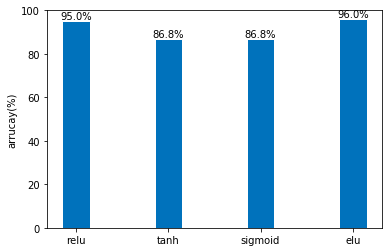

In [61]:
subjects = ['relu','tanh','sigmoid','elu']
scores = [95,86.8,86.8,96]

bar_width = 0.30
index = np.arange(len(scores))

rects1 = plt.bar(index, scores, bar_width, color='#0072BC', label=subjects)


plt.xticks(index,subjects)
plt.ylim(ymax=100, ymin=0)
plt.ylabel("arrucay(%)") 

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height,str(height)+'%', ha='center', va='bottom')
        rect.set_edgecolor('white')
 
add_labels(rects1)

plt.savefig('performance_comparence1.png')
plt.show()

# Test the final model

In [62]:
def cnn_clf_new(features, labels, mode):
  #Input layer
  input_layer = tf.reshape(features, [-1, 28, 28, 1])

  #Convolutional layer 1
  conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],padding="same",activation=tf.nn.elu)

  #Pooling layer 1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  #Convolutional layer 2
  conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.elu)
  
  #Pooling layer 2
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  #Fully connected layer
  fc_input = tf.reshape(pool2, [-1, 7 * 7 * 64])
  fc = tf.layers.dense(inputs=fc_input, units=1024, activation=tf.nn.elu)
  dropout = tf.layers.dropout(inputs=fc, rate=0.4, training= mode == learn.ModeKeys.TRAIN)

  #Softmax layer
  output = tf.layers.dense(inputs=dropout, units=10)

  loss = None
  train_op = None

  # Calculate Loss
  if mode != learn.ModeKeys.INFER:
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=output)

  # Configure the Training Op (for TRAIN mode)
  if mode == learn.ModeKeys.TRAIN:
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=0.001,
        optimizer="SGD")

  # Generate Predictions
  predictions = {
      "classes": tf.argmax(
          input=output, axis=1),
      "probabilities": tf.nn.softmax(
          output, name="softmax_tensor")
  }
  # Return a ModelFnOps object
  return model_fn_lib.ModelFnOps(mode=mode, predictions=predictions, loss=loss, train_op=train_op)

# Create the Estimator
mnist_classifier5 = learn.Estimator(model_fn=cnn_elu, model_dir="/tmp/mnist_cnn_clf_new")

# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=100)

# Train the model
mnist_classifier5.fit(x=X_train,y=y_train,batch_size=100,steps=2000,monitors=[logging_hook])

# Configure the accuracy metric for evaluation
metrics = {"accuracy":learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="classes")}

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B7032A8588>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/mnist_cnn_clf_new'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/mnist_cnn_clf_new\model.ckpt.
INFO:tensorflow:probabilities = [[0.   

INFO:tensorflow:loss = 62.740047454833984, step = 1
INFO:tensorflow:global_step/sec: 3.1907
INFO:tensorflow:probabilities = [[0.00999784 0.00043022 0.9550523  0.00238791 0.00020677 0.00004201
  0.0007663  0.00033425 0.00754409 0.02323831]
 [0.00086638 0.00186829 0.00040724 0.00263329 0.09448237 0.01156875
  0.00089654 0.01953285 0.85419255 0.01355174]
 [0.00003851 0.00000883 0.00006592 0.00054037 0.75149741 0.00000919
  0.0006324  0.00007608 0.00002555 0.24710574]
 [0.00088194 0.00006616 0.00000288 0.0004124  0.00012785 0.95111563
  0.0337242  0.00005636 0.01264834 0.00096425]
 [0.00078516 0.00007491 0.00000122 0.00001039 0.00000825 0.98689836
  0.00115178 0.00727437 0.00377702 0.00001853]
 [0.00025029 0.00164563 0.02013776 0.00016437 0.00042691 0.01633043
  0.95909188 0.00000926 0.00114873 0.00079473]
 [0.00014174 0.99257874 0.00135027 0.0006825  0.00021079 0.00007423
  0.00000494 0.00137406 0.00348886 0.00009385]
 [0.00160024 0.00000009 0.83531396 0.16072505 0.00000181 0.00003898
  0

INFO:tensorflow:loss = 0.513882040977478, step = 101 (31.349 sec)
INFO:tensorflow:global_step/sec: 3.19171
INFO:tensorflow:probabilities = [[0.7024554  0.00002675 0.18882751 0.00060003 0.00002596 0.04494106
  0.04899349 0.00143536 0.00006042 0.01263404]
 [0.99998578 0.00000001 0.00000261 0.00000004 0.         0.00001152
  0.         0.         0.00000004 0.        ]
 [0.99436874 0.00000483 0.00082295 0.000015   0.0000029  0.00000069
  0.00097201 0.00002079 0.00004497 0.00374713]
 [0.00002263 0.00000024 0.00000146 0.00000021 0.00004264 0.00238249
  0.00000146 0.84029562 0.00001829 0.15723497]
 [0.00000001 0.0000001  0.00000006 0.01580151 0.00000087 0.98419607
  0.00000026 0.00000003 0.00000064 0.00000045]
 [0.00003723 0.00018538 0.00005936 0.0012651  0.24201161 0.00001666
  0.00251229 0.53701172 0.00003112 0.21686953]
 [0.02916852 0.00002731 0.0082807  0.03434229 0.00013011 0.33575355
  0.00426544 0.00071957 0.57292766 0.01438485]
 [0.00000027 0.00000138 0.00048785 0.00000711 0.98917138

INFO:tensorflow:loss = 0.3235204219818115, step = 201 (31.325 sec)
INFO:tensorflow:global_step/sec: 3.04681
INFO:tensorflow:probabilities = [[0.94162681 0.0001916  0.00006793 0.00754123 0.00002904 0.0320104
  0.00000481 0.00027431 0.00017733 0.01807654]
 [0.00157152 0.00347022 0.98884448 0.00055569 0.00064492 0.00044595
  0.00004574 0.00000572 0.0002701  0.00414565]
 [0.00000309 0.00000031 0.00000559 0.01020889 0.00000274 0.98825846
  0.00004775 0.00000021 0.00146588 0.00000707]
 [0.00000026 0.00000012 0.00000832 0.98913185 0.         0.01085874
  0.00000013 0.00000021 0.00000037 0.        ]
 [0.         0.00000002 0.00000002 0.         0.00000032 0.00000473
  0.99999486 0.         0.00000006 0.        ]
 [0.00000048 0.         0.00000178 0.00000001 0.00000004 0.
  0.         0.99992339 0.00000029 0.00007401]
 [0.         0.         0.0000001  0.00000736 0.00000001 0.99997285
  0.00000008 0.         0.00001957 0.00000002]
 [0.00000032 0.00000232 0.00026759 0.9956287  0.00000162 0.00374

INFO:tensorflow:loss = 0.3433254361152649, step = 301 (32.822 sec)
INFO:tensorflow:global_step/sec: 3.00472
INFO:tensorflow:probabilities = [[0.00000146 0.00000124 0.00002252 0.99893698 0.00000017 0.00099471
  0.00002538 0.00001178 0.00000442 0.00000134]
 [0.00279027 0.00792292 0.03183382 0.86985635 0.00100807 0.06470982
  0.00000015 0.00634491 0.01486042 0.00067327]
 [0.         0.         0.00000001 0.9997501  0.         0.00024611
  0.         0.         0.00000378 0.        ]
 [0.00003085 0.00000001 0.00000058 0.00000017 0.00000623 0.01349926
  0.00000001 0.0000088  0.98358555 0.00286854]
 [0.00000097 0.00000001 0.00000013 0.00009664 0.00064495 0.99882984
  0.00001102 0.00000014 0.00038323 0.00003307]
 [0.99904964 0.00000056 0.0000048  0.00029207 0.00000002 0.00001256
  0.00000026 0.00012906 0.00000227 0.00050876]
 [0.00000008 0.00000001 0.00000002 0.00000203 0.99985143 0.
  0.         0.00000568 0.00000002 0.00014073]
 [0.00000273 0.00002296 0.00000637 0.00000096 0.00000302 0.0000

INFO:tensorflow:loss = 0.12897473573684692, step = 401 (33.388 sec)
INFO:tensorflow:global_step/sec: 3.20836
INFO:tensorflow:probabilities = [[0.01429166 0.00000117 0.00233535 0.00033519 0.00000927 0.00003251
  0.00000005 0.98206329 0.00003045 0.00090105]
 [0.00054051 0.00000616 0.00279457 0.00013263 0.74573984 0.06901397
  0.14623986 0.00001078 0.00028122 0.03524046]
 [0.00000013 0.00000005 0.00000198 0.00000043 0.99855571 0.00000151
  0.00000238 0.00046084 0.00054019 0.00043678]
 [0.00000014 0.00000401 0.00000213 0.00000865 0.99992947 0.00000138
  0.00000836 0.0000002  0.00001148 0.00003418]
 [0.00000206 0.00000922 0.00003188 0.00004206 0.00049246 0.00014222
  0.9948061  0.00000211 0.00444688 0.00002501]
 [0.00000001 0.         0.99999986 0.         0.         0.
  0.00000012 0.         0.00000001 0.        ]
 [0.99998154 0.00000079 0.00000414 0.         0.00000003 0.
  0.00000119 0.00000001 0.00000909 0.00000321]
 [0.99999273 0.         0.00000369 0.00000015 0.         0.
  0.      

INFO:tensorflow:loss = 0.11379606276750565, step = 501 (31.061 sec)
INFO:tensorflow:global_step/sec: 3.19232
INFO:tensorflow:probabilities = [[0.         0.00000002 0.00000133 0.00000021 0.         0.
  0.         0.99999833 0.         0.0000001 ]
 [0.00000672 0.00000001 0.00000213 0.00000969 0.00001529 0.00001958
  0.         0.00108565 0.0000003  0.99886064]
 [0.00000002 0.00000055 0.00000003 0.         0.00000662 0.00000019
  0.99998353 0.         0.00000904 0.00000001]
 [0.00000494 0.00000063 0.99751604 0.0000298  0.00182187 0.00010711
  0.00049484 0.00000003 0.00000048 0.00002426]
 [0.00000542 0.00000079 0.99999054 0.00000095 0.00000042 0.
  0.0000002  0.         0.00000005 0.00000162]
 [0.0000001  0.00000018 0.00007685 0.0039128  0.00000008 0.00000071
  0.         0.00000087 0.99600832 0.00000009]
 [0.78787133 0.00002619 0.01189468 0.00015698 0.00104303 0.00017714
  0.19880393 0.00000194 0.00000262 0.00002215]
 [0.0006416  0.00000463 0.00033506 0.99819714 0.00000152 0.00002222
  

INFO:tensorflow:loss = 0.16136768460273743, step = 601 (31.325 sec)
INFO:tensorflow:global_step/sec: 3.14634
INFO:tensorflow:probabilities = [[0.99970746 0.00000014 0.00001152 0.00000017 0.00000001 0.00001958
  0.         0.00000139 0.00000319 0.00025654]
 [0.         0.         0.         0.00000005 0.00000098 0.00000054
  0.99999842 0.         0.         0.        ]
 [0.         0.00001245 0.00000001 0.0000418  0.99978309 0.00000005
  0.00000001 0.00000007 0.00008965 0.00007288]
 [0.00000746 0.         0.00000004 0.00000005 0.00000014 0.00000002
  0.99999215 0.         0.00000015 0.        ]
 [0.00040178 0.01066561 0.97498765 0.01152288 0.00001971 0.00086541
  0.00033972 0.00000271 0.00110246 0.00009206]
 [0.         0.00000176 0.00004934 0.00000089 0.99971129 0.00000008
  0.00000006 0.00000117 0.0000229  0.00021252]
 [0.00000005 0.         0.         0.00000025 0.00000003 0.99999894
  0.         0.         0.00000003 0.0000007 ]
 [0.00000001 0.         0.         0.         0.      

INFO:tensorflow:loss = 0.18577618896961212, step = 701 (31.784 sec)
INFO:tensorflow:global_step/sec: 3.21195
INFO:tensorflow:probabilities = [[0.00009508 0.01504207 0.9767244  0.00004336 0.00001448 0.00000041
  0.00798285 0.00000118 0.00009611 0.00000008]
 [0.00000001 0.00000011 0.0000026  0.99999202 0.         0.00000474
  0.00000001 0.00000002 0.00000049 0.        ]
 [0.00000198 0.00306963 0.00015102 0.00003453 0.00252707 0.00038508
  0.00000039 0.00017233 0.99340842 0.00024955]
 [0.00000262 0.99752413 0.00000213 0.00026968 0.00035533 0.00006768
  0.00002122 0.0000681  0.00168485 0.00000426]
 [0.00000251 0.00000195 0.99997383 0.00001237 0.00000001 0.00000002
  0.00000824 0.0000009  0.00000017 0.        ]
 [0.00000006 0.00001102 0.00000092 0.00012136 0.98991112 0.00003135
  0.0094965  0.00011454 0.0003039  0.00000924]
 [0.97810177 0.00001684 0.01828628 0.00002551 0.00004339 0.00000032
  0.00334894 0.00014927 0.00001133 0.00001636]
 [0.00000004 0.99718711 0.00000438 0.00002256 0.002657

INFO:tensorflow:loss = 0.11034958064556122, step = 801 (31.500 sec)
INFO:tensorflow:global_step/sec: 3.15069
INFO:tensorflow:probabilities = [[0.00008524 0.65053307 0.00027776 0.00005822 0.33151594 0.00001645
  0.00021968 0.01716638 0.00009607 0.00003118]
 [0.81414437 0.00291459 0.00111806 0.00004637 0.00227682 0.0000337
  0.1750852  0.0000166  0.0035666  0.00079769]
 [0.00000508 0.00000037 0.99796073 0.00181611 0.0000121  0.00000007
  0.0000206  0.00010068 0.000082   0.00000226]
 [0.99999925 0.00000001 0.00000001 0.         0.         0.00000038
  0.         0.         0.00000029 0.00000005]
 [0.         0.00000006 0.0000502  0.99966941 0.00000622 0.0001607
  0.00011144 0.0000006  0.00000136 0.        ]
 [0.         0.         0.00000004 0.99992215 0.00000008 0.00007745
  0.00000001 0.00000002 0.00000006 0.00000018]
 [0.00000005 0.         0.         0.00000122 0.00000005 0.99999689
  0.0000004  0.00000121 0.00000013 0.00000005]
 [0.76811657 0.00004938 0.00005676 0.0000024  0.00112459

INFO:tensorflow:loss = 0.22938580811023712, step = 901 (31.373 sec)
INFO:tensorflow:global_step/sec: 3.09975
INFO:tensorflow:probabilities = [[0.0000028  0.00000009 0.00000024 0.         0.0000521  0.00000015
  0.         0.00013167 0.00000106 0.99981189]
 [0.         0.         0.00000001 0.99999985 0.         0.00000011
  0.         0.00000001 0.00000002 0.        ]
 [0.00000002 0.00000001 0.00000005 0.00000008 0.00000027 0.00000002
  0.         0.00000057 0.99999819 0.0000008 ]
 [0.00001932 0.00000003 0.00000186 0.66098364 0.00001411 0.29400776
  0.00000559 0.00001937 0.0448537  0.00009462]
 [0.00000326 0.0000019  0.00000063 0.00001628 0.00000323 0.00005811
  0.00097932 0.00000017 0.99893519 0.00000192]
 [0.00000007 0.00015953 0.00000268 0.00002719 0.00000187 0.00001032
  0.0002182  0.         0.99957969 0.00000047]
 [0.00000006 0.         0.00000004 0.98173903 0.00000001 0.0182529
  0.         0.00000001 0.00000028 0.00000768]
 [0.26960962 0.00248577 0.01737312 0.00021599 0.0005303

INFO:tensorflow:loss = 0.10887804627418518, step = 1001 (32.261 sec)
INFO:tensorflow:global_step/sec: 3.20949
INFO:tensorflow:probabilities = [[0.99999976 0.         0.00000002 0.         0.         0.00000014
  0.         0.         0.00000001 0.00000006]
 [0.         0.00000006 0.         0.00000004 0.00053426 0.
  0.         0.00000002 0.00001413 0.99945149]
 [0.00000001 0.00000004 0.00000129 0.99998915 0.00000005 0.00000772
  0.         0.00000055 0.00000011 0.00000107]
 [0.00026182 0.99668183 0.00000329 0.00000025 0.00009663 0.00208529
  0.00048577 0.00000239 0.00029457 0.00008817]
 [0.99999838 0.         0.         0.         0.         0.00000002
  0.         0.         0.00000037 0.00000121]
 [0.00000029 0.99984209 0.00000004 0.00015592 0.0000005  0.00000022
  0.00000001 0.00000062 0.00000028 0.00000003]
 [0.00000073 0.00200262 0.00070117 0.01328408 0.00264449 0.00000634
  0.00000065 0.00367251 0.24473902 0.73294838]
 [0.00000057 0.99998367 0.00000015 0.00000003 0.0000007  0.00

INFO:tensorflow:loss = 0.014545348472893238, step = 1101 (31.165 sec)
INFO:tensorflow:global_step/sec: 3.12428
INFO:tensorflow:probabilities = [[0.         0.         0.         0.00000001 0.00000073 0.
  0.         0.00001096 0.00000001 0.99998829]
 [0.00001014 0.         0.00000009 0.00000109 0.00000289 0.00000002
  0.         0.00002857 0.00000281 0.99995439]
 [0.00000115 0.00019853 0.00000473 0.00000017 0.99904952 0.00000024
  0.00009667 0.00021152 0.00043219 0.00000528]
 [0.         0.         0.99999962 0.00000025 0.         0.
  0.         0.         0.         0.00000013]
 [0.00000001 0.00000055 0.00001077 0.00000679 0.99935532 0.00000001
  0.00000006 0.00000076 0.00000033 0.00062542]
 [0.         0.         0.         0.99999507 0.         0.00000491
  0.         0.         0.00000001 0.        ]
 [0.00002882 0.00000027 0.00000027 0.00000027 0.00039562 0.07394959
  0.92027406 0.         0.00535107 0.00000002]
 [0.00000078 0.00030828 0.00000141 0.00902907 0.00055127 0.00000086


INFO:tensorflow:loss = 0.18256376683712006, step = 1201 (32.130 sec)
INFO:tensorflow:global_step/sec: 2.98789
INFO:tensorflow:probabilities = [[0.00000001 0.00000005 0.00000005 0.00056448 0.00000005 0.99943469
  0.00000004 0.00000001 0.00000053 0.00000009]
 [0.00000008 0.00026533 0.00003481 0.00001565 0.00661225 0.00000009
  0.00000024 0.98781996 0.00518201 0.0000696 ]
 [0.00008578 0.99346491 0.00044388 0.0032017  0.00027228 0.00187676
  0.00003558 0.00005426 0.00030465 0.00026019]
 [0.000007   0.00000023 0.00000032 0.00000041 0.00000014 0.00000068
  0.         0.99998683 0.0000043  0.00000008]
 [0.00000793 0.00705776 0.00004561 0.00000712 0.98524361 0.00000397
  0.00070943 0.00426396 0.00002705 0.00263356]
 [0.00000591 0.00000976 0.00026276 0.0008012  0.99702414 0.00000892
  0.00006733 0.00001246 0.00158698 0.00022054]
 [0.00000038 0.         0.00000001 0.000025   0.         0.
  0.         0.99969529 0.         0.00027932]
 [0.00000009 0.99991101 0.00005464 0.00000001 0.00000848 0.
 

INFO:tensorflow:loss = 0.03159430995583534, step = 1301 (33.338 sec)
INFO:tensorflow:global_step/sec: 3.23413
INFO:tensorflow:probabilities = [[0.0000001  0.         0.00000903 0.00000966 0.         0.00000018
  0.         0.99997837 0.00000252 0.00000013]
 [0.00002317 0.81733435 0.04386845 0.00000868 0.0885879  0.0000007
  0.00154067 0.00002149 0.04860702 0.00000756]
 [0.00000001 0.         0.0000032  0.9999965  0.         0.
  0.         0.00000019 0.         0.00000009]
 [0.00000561 0.00014858 0.00005507 0.04973154 0.00001561 0.00000148
  0.00000001 0.94083486 0.00002656 0.00918068]
 [0.87961221 0.00342287 0.00103281 0.00014598 0.00067251 0.0005979
  0.02943769 0.00004449 0.08477133 0.00026224]
 [0.00000012 0.00000023 0.00000021 0.00001926 0.00000115 0.99853852
  0.00000028 0.00024441 0.00000182 0.001194  ]
 [0.00000001 0.         0.00000006 0.         0.         0.
  0.         0.99999991 0.         0.00000002]
 [0.00000005 0.00001071 0.00568225 0.96137425 0.00000101 0.00000004
  0

INFO:tensorflow:loss = 0.0636783316731453, step = 1401 (30.919 sec)
INFO:tensorflow:global_step/sec: 3.1203
INFO:tensorflow:probabilities = [[0.00009493 0.00069889 0.0014118  0.00000647 0.0000011  0.00000006
  0.00000043 0.99769045 0.00000056 0.0000953 ]
 [0.00000722 0.00000001 0.         0.00000075 0.00000004 0.00762722
  0.00000021 0.00232428 0.00000007 0.9900402 ]
 [0.         0.         0.         0.00000134 0.         0.99999225
  0.00000638 0.         0.00000002 0.        ]
 [0.99999638 0.         0.00000005 0.         0.         0.00000002
  0.0000033  0.         0.00000024 0.00000001]
 [0.00000001 0.         0.         0.         0.00000001 0.
  0.         0.         0.99999997 0.00000001]
 [0.000056   0.00000026 0.00000104 0.00000137 0.         0.99993494
  0.00000269 0.00000087 0.00000275 0.00000007]
 [0.99380298 0.00001756 0.00570931 0.00001583 0.00000001 0.00001249
  0.00000636 0.00000164 0.0004303  0.00000352]
 [0.00000015 0.99955335 0.00000008 0.00000019 0.00012203 0.0000

INFO:tensorflow:loss = 0.0529257096350193, step = 1501 (32.049 sec)
INFO:tensorflow:global_step/sec: 3.0574
INFO:tensorflow:probabilities = [[0.00001397 0.00000776 0.00007846 0.00027801 0.00000063 0.00000887
  0.00000079 0.00000001 0.99942471 0.00018679]
 [0.         0.         0.00003038 0.00000003 0.         0.00000002
  0.         0.         0.99996924 0.00000033]
 [0.00000007 0.999952   0.00000481 0.00000133 0.00000292 0.
  0.00000025 0.00002882 0.00000978 0.00000002]
 [0.0000026  0.00000063 0.00000353 0.00048545 0.         0.00000176
  0.         0.9986392  0.00000028 0.00086655]
 [0.00000003 0.00000036 0.00000198 0.0000024  0.00033205 0.00060975
  0.00002913 0.         0.9989751  0.0000492 ]
 [0.00030299 0.00007641 0.00001399 0.99839604 0.00013124 0.00101183
  0.00000287 0.00003183 0.00000545 0.00002736]
 [0.00129569 0.00010963 0.00116701 0.00010993 0.0000035  0.0000004
  0.00000007 0.00000047 0.99726528 0.00004801]
 [0.00000726 0.00000001 0.00000029 0.         0.00014775 0.00000

INFO:tensorflow:loss = 0.11887108534574509, step = 1601 (32.738 sec)
INFO:tensorflow:global_step/sec: 3.00472
INFO:tensorflow:probabilities = [[0.         0.         0.00000003 0.         0.00000005 0.00000172
  0.99999808 0.         0.00000011 0.        ]
 [0.00000134 0.99982202 0.00003131 0.0000074  0.00000191 0.00000098
  0.00000005 0.00000964 0.00012513 0.00000022]
 [0.00000002 0.         0.00000025 0.         0.         0.
  0.         0.99999972 0.         0.00000001]
 [0.00000839 0.00000005 0.00000001 0.         0.00000246 0.00000023
  0.99998877 0.00000008 0.         0.        ]
 [0.         0.         0.00000015 0.04810613 0.00000001 0.95136595
  0.00000001 0.00000095 0.0005212  0.00000558]
 [0.         0.00000317 0.00000019 0.00000008 0.999265   0.
  0.00000595 0.00070982 0.00001561 0.00000018]
 [0.99998161 0.00000003 0.00000612 0.00001194 0.         0.00000001
  0.         0.         0.00000028 0.00000001]
 [0.         0.00002019 0.00000008 0.00000005 0.99995554 0.00000001
 

INFO:tensorflow:loss = 0.07088975608348846, step = 1701 (33.250 sec)
INFO:tensorflow:global_step/sec: 2.97866
INFO:tensorflow:probabilities = [[0.00000204 0.00000434 0.00000331 0.00000029 0.00076456 0.00000001
  0.         0.99771328 0.00000001 0.00151217]
 [0.99923841 0.00000004 0.00000012 0.00000005 0.00000001 0.00002898
  0.00000024 0.         0.00054432 0.00018783]
 [0.00000001 0.         0.00000023 0.00000005 0.00000029 0.
  0.         0.00031791 0.00000002 0.99968149]
 [0.         0.         0.         0.         0.00000063 0.
  0.         0.0000003  0.00000018 0.99999889]
 [0.00000044 0.00048992 0.99828967 0.00010113 0.00001785 0.00000001
  0.00000057 0.00000095 0.00109932 0.00000013]
 [0.99997538 0.00000001 0.0000021  0.         0.00000001 0.
  0.00002185 0.00000001 0.00000043 0.00000022]
 [0.00000269 0.00000001 0.99990737 0.00000037 0.         0.
  0.00000883 0.00000001 0.00008071 0.        ]
 [0.00000021 0.         0.00000009 0.00000001 0.00000001 0.00003916
  0.         0.00

INFO:tensorflow:loss = 0.06170543655753136, step = 1801 (33.571 sec)
INFO:tensorflow:Saving checkpoints for 1873 into /tmp/mnist_cnn_clf_new\model.ckpt.
INFO:tensorflow:global_step/sec: 3.10236
INFO:tensorflow:probabilities = [[0.00143342 0.         0.99856281 0.00000012 0.         0.
  0.00000026 0.00000244 0.00000095 0.        ]
 [0.00000157 0.00000683 0.99982358 0.00001432 0.00000019 0.00000002
  0.00000003 0.00000146 0.0001517  0.00000031]
 [0.0000006  0.00000001 0.00010266 0.00001443 0.00000112 0.00000047
  0.00000121 0.         0.99986588 0.00001362]
 [0.00001868 0.00016635 0.00006861 0.00000026 0.00075187 0.00006373
  0.99889408 0.00000025 0.00003537 0.00000078]
 [0.00000018 0.00000184 0.00000006 0.00000005 0.00003875 0.00000483
  0.         0.99992078 0.0000203  0.00001321]
 [0.         0.00000177 0.00000002 0.00000005 0.99991915 0.00000003
  0.00000007 0.0000491  0.00000033 0.00002947]
 [0.00000183 0.99815337 0.00000129 0.00000006 0.00135037 0.00000555
  0.00042176 0.00003509 

INFO:tensorflow:loss = 0.044435806572437286, step = 1901 (32.233 sec)
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/mnist_cnn_clf_new\model.ckpt.
INFO:tensorflow:Loss for final step: 0.055221691727638245.


# Test result

In [69]:
def reload_data(path,num):
    data = csv.reader(open(path,'r'))
    labels=[]
    images=[]
    for item in data:
        labels.append(num)
        images.append(item[1:])   
    # data[0] is the lable of each column
    # item[0] is the index of images
    # omit these 2 things 
    labels.pop(0)
    images.pop(0)
    return np.array(images,dtype=np.float64),np.array(labels,dtype=np.int32)

In [72]:
tcName = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
tst = time.clock()
allErrCount = 0
allErrorRate = 0.0
allScore = 0.0
for tcn  in tcName:
    tdataMat,tdataLabel = reload_data('%s.csv'%tcn,tcn)
    print("test dataMat shape: ",tdataMat.shape,"test dataLabel len: ",len(tdataLabel))
    #print("test dataLabel: {}".format(len(tdataLabel)))
    pre_st = time.clock()
    preResult = mnist_classifier5.evaluate(x=tdataMat, y=tdataLabel, metrics=metrics)
    pre_et = time.clock()
    print("Recognition",tcn,"spent",'%.4fs' % (pre_et-pre_st))
    #print("predict result: {}".format(len(preResult)))
    errCount = int((1-preResult['accuracy'])*200)
    print("errorCount:",errCount)
    allErrCount += errCount
    score_st = time.clock()
    score = preResult['accuracy']
    score_et = time.clock()
    print("computing score spent",'%.4fs' %(score_et-score_st))
    allScore += score
    print("score:",'%.6f' %score)
    print("error rate is",'%.6f' %(1-score))
    print("---------------------------------------------------------")


tet = time.clock()
print("Testing All class total spent",'%.6fs' %(tet-tst))
print("All error Count is:",allErrCount)
avgAccuracy = allScore/10.0
print("Average accuracy is:",'%.6f' %avgAccuracy)
print("Average error rate is:",'%.6f' % (1-avgAccuracy))

test dataMat shape:  (200, 784) test dataLabel len:  200
INFO:tensorflow:Starting evaluation at 2018-12-05-07:13:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_cnn_clf_new\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-05-07:13:28
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.99, global_step = 2000, loss = 0.020470211
Recognition 0 spent 1.0226s
errorCount: 1
computing score spent 0.0000s
score: 0.990000
error rate is 0.010000
---------------------------------------------------------
test dataMat shape:  (200, 784) test dataLabel len:  200
INFO:tensorflow:Starting evaluation at 2018-12-05-07:13:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_cnn_clf_new\model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluat